In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.signal as signal


In [3]:
# Data is in ./data folder in this convention for the filename
# <session_number>_<shoes_name>_<coating>.csv
# e.g. 001_newbalance_bitume.csv
# Now we can load the data with pandas
# We can use the read_csv function
def get_files():
    files = os.listdir('./data')
    return files

def parse_filename(filename):
    filename = filename.replace('.csv', '')
    session, shoes, coating = filename.split('_')
    return session, shoes, coating;

def load_data(filename):
    df = pd.read_csv('./data/' + filename)
    return df

channel_offsets = {
    'Channel 1': 36.98,
    'Channel 2': 196.34,
    'Channel 3': 69.57,
    'Channel 4': -107.74,
}

def get_all_data():
    files = get_files()
    data = []
    for file in files:
        if not file.endswith('.csv'):
            continue
        session, shoes, coating = parse_filename(file)
        df = load_data(file)
        # Change the time column from an interval to actual time, we use the cumsum function
        df['Time'] = np.cumsum(df['Time'])
        # Now find the minimum value of each channel and substract it to the channel
        for channel in ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4']:
            df[channel] = df[channel] - channel_offsets[channel]


        data.append((session, shoes, coating, df))
    # Order the data by shoes and coating
    data = sorted(data, key=lambda x: (x[1], x[2]))
    
    return data

datas = get_all_data()
len (datas)

6

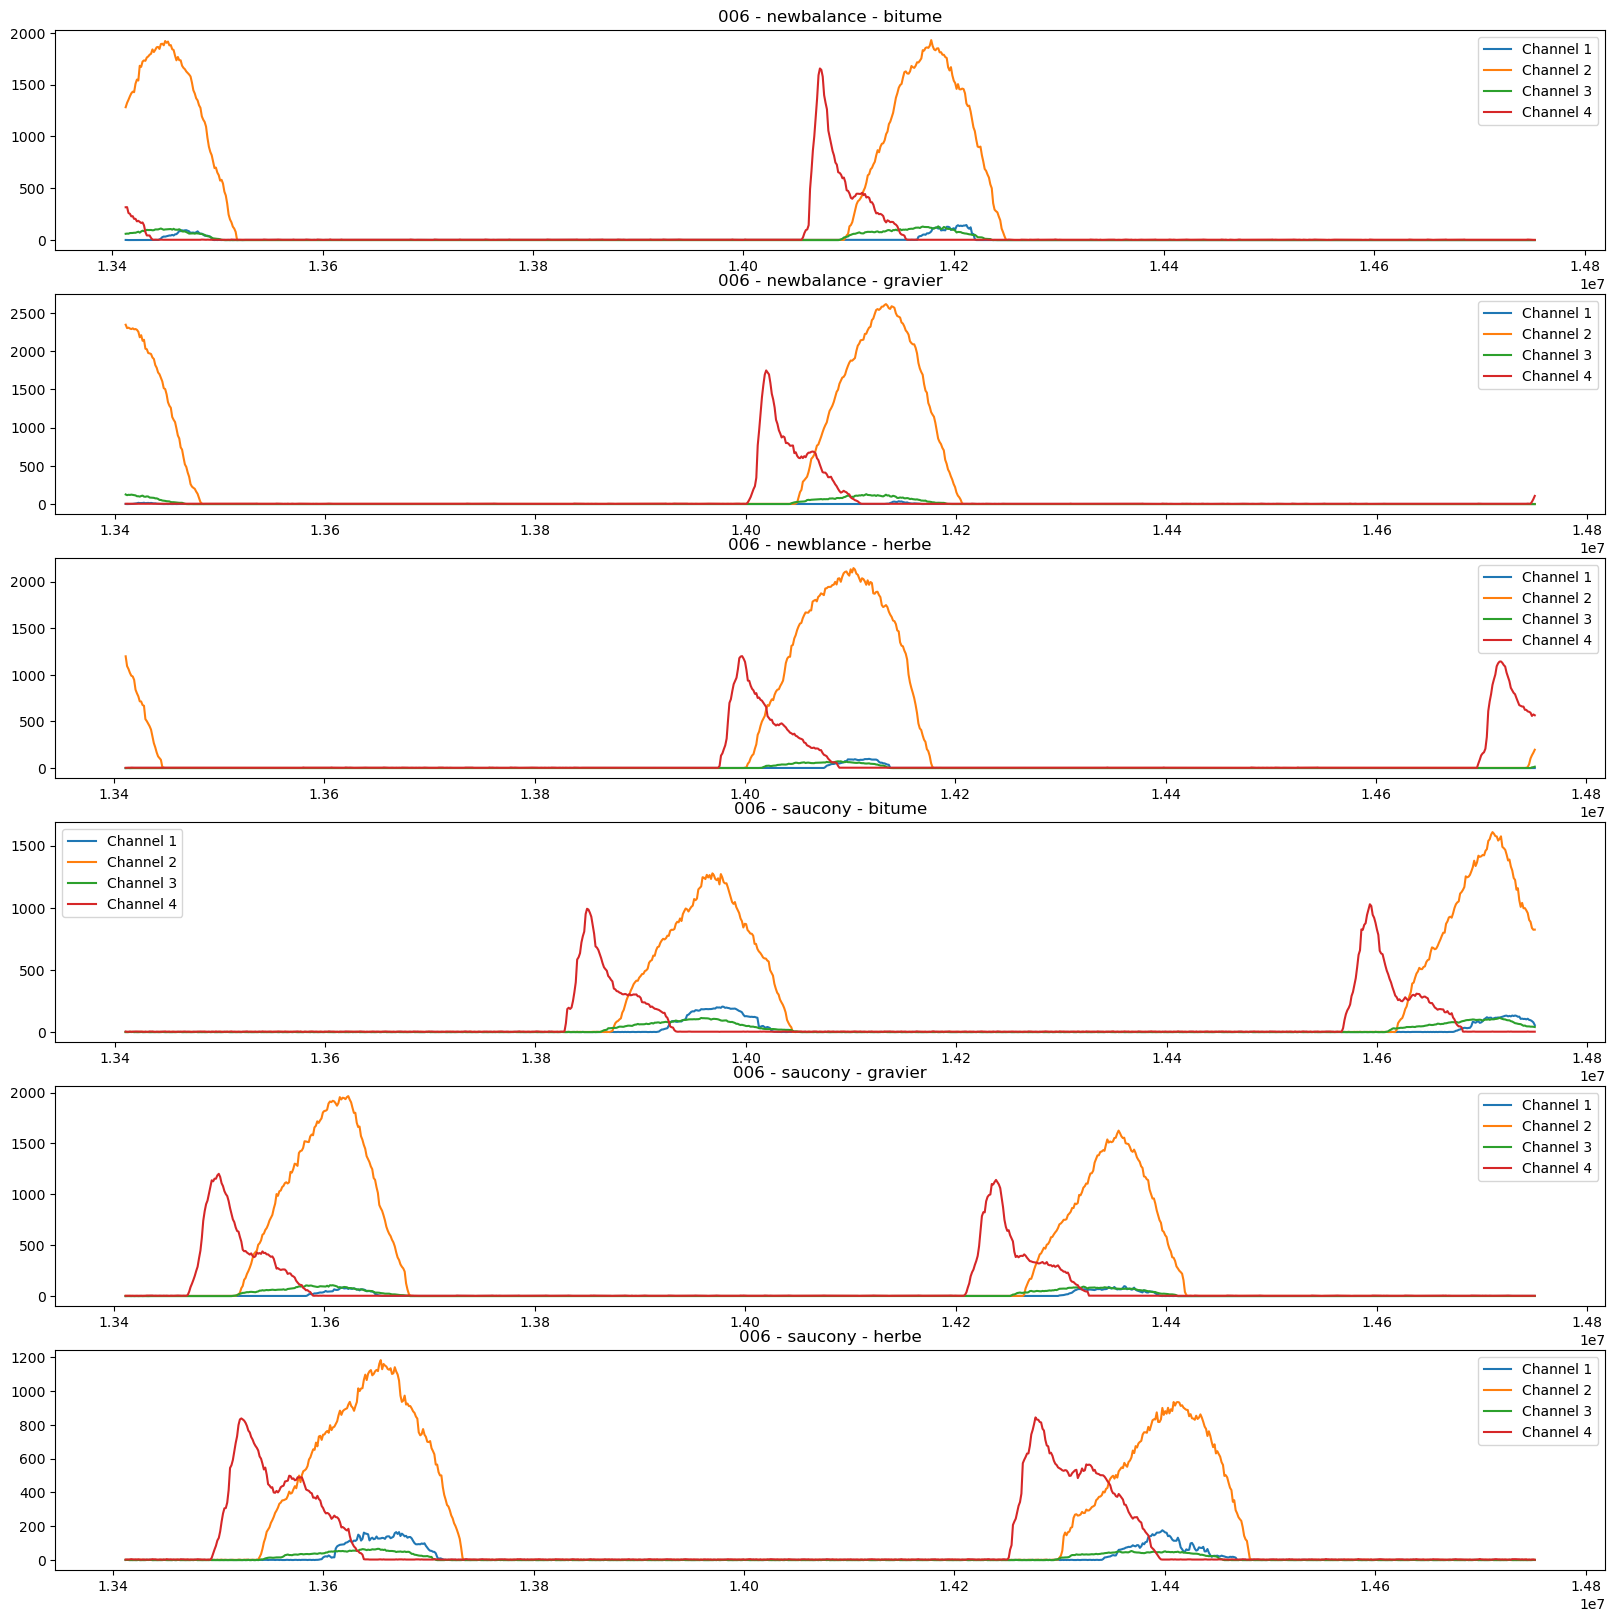

In [4]:
def plot_data(data):
    # Plot in subplots for each entry
    fig, axs = plt.subplots(len(data), 1, figsize=(20, 20))
    for i, (session, shoes, coating, df) in enumerate(data):
        for channel in ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4']:
            df_trim = df[10000:11000]
            axs[i].plot(df_trim['Time'], df_trim[channel], label=channel)
        axs[i].set_title(f'{session} - {shoes} - {coating}')
        axs[i].legend()

plot_data(datas)

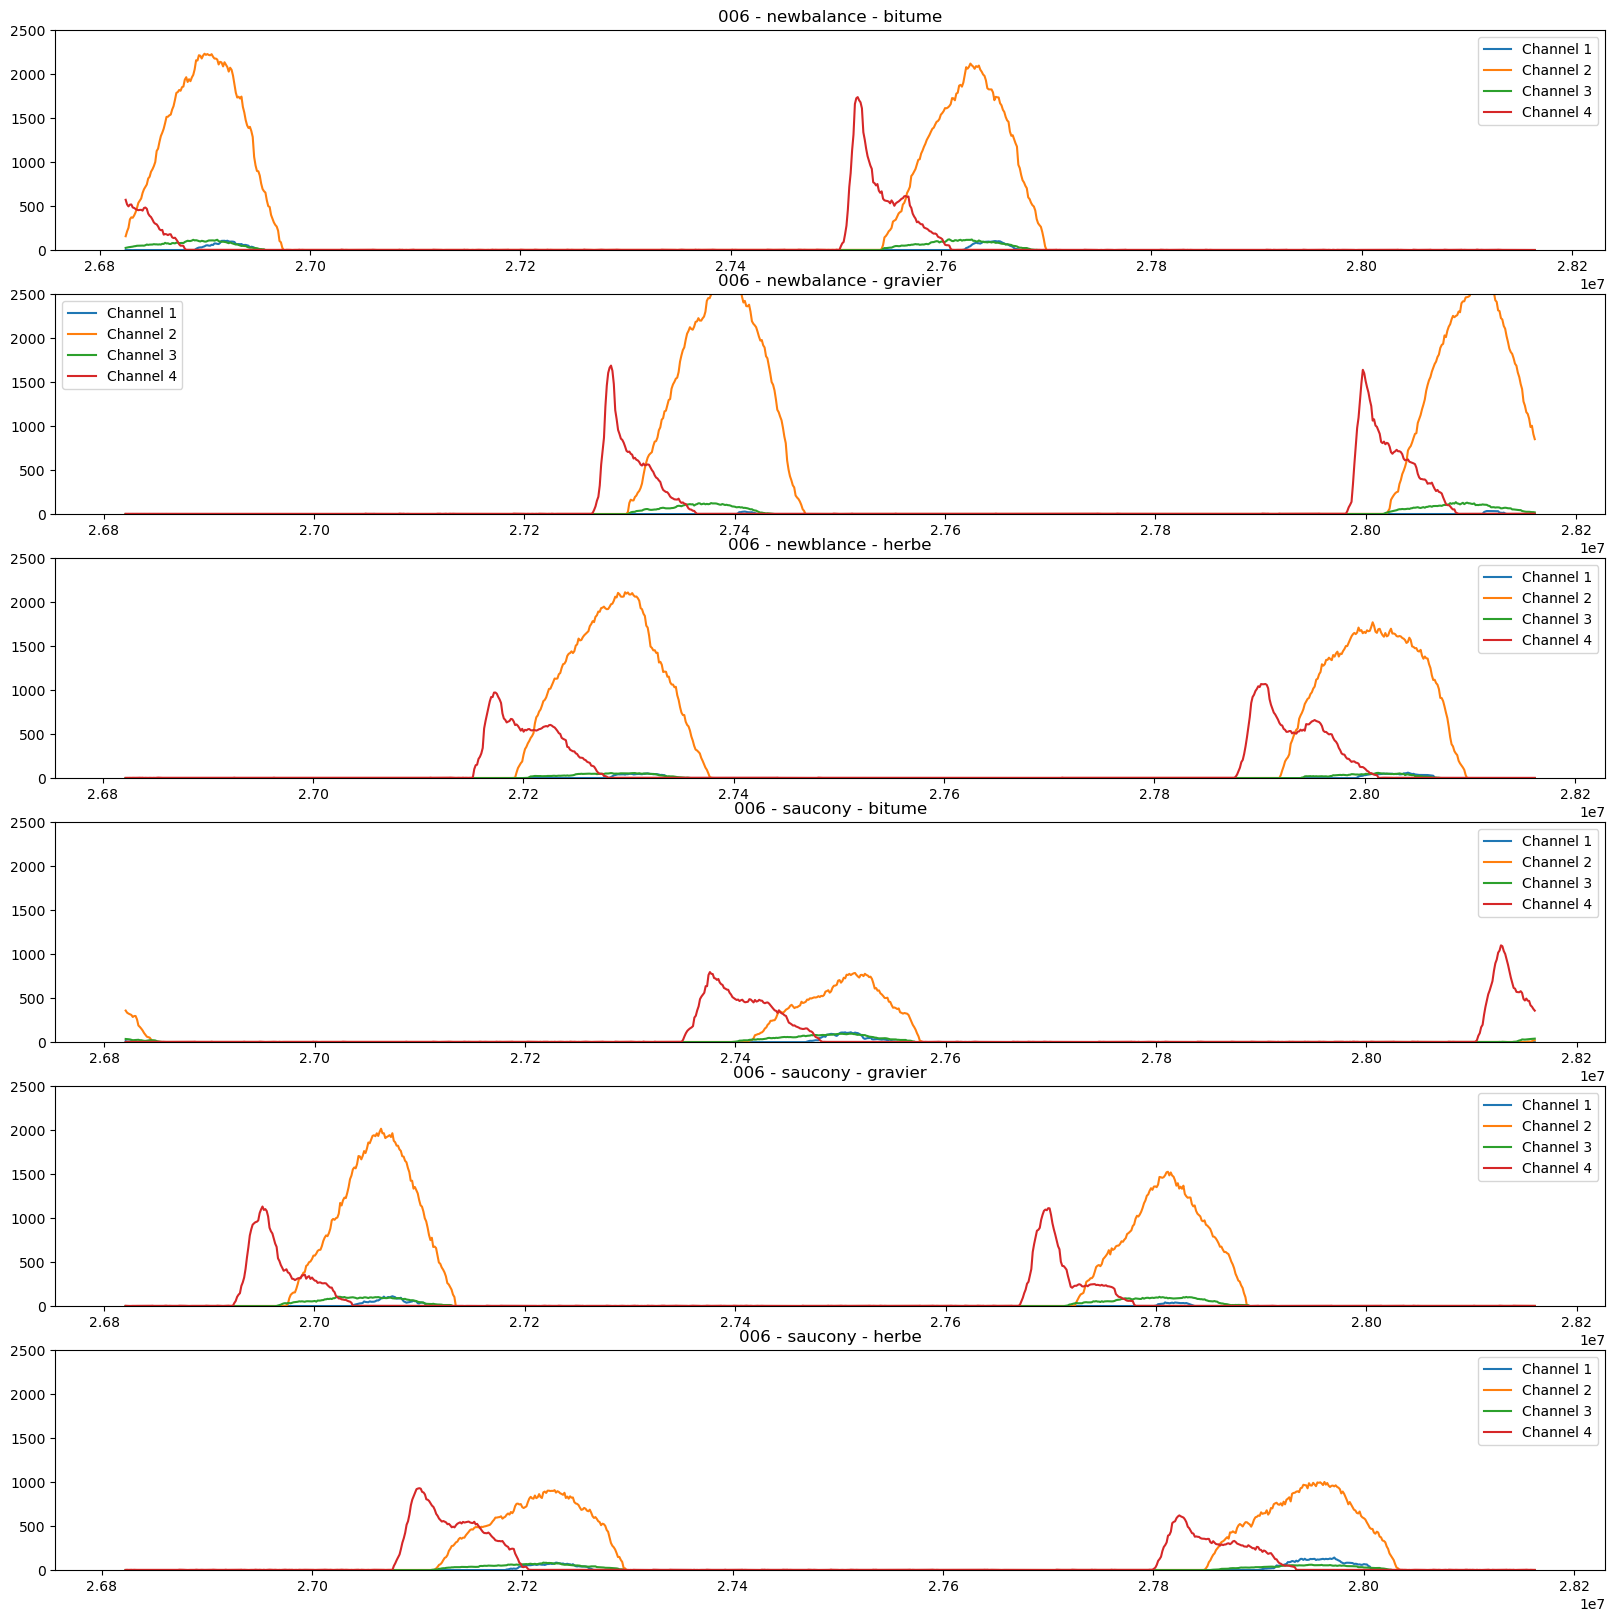

In [5]:
# Plot the data with the same scale
def plot_data_same_scale(data):
    fig, axs = plt.subplots(len(data), 1, figsize=(20, 20))
    for i, (session, shoes, coating, df) in enumerate(data):
        for channel in ['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4']:
            df_trim = df[20000:21000]
            axs[i].plot(df_trim['Time'], df_trim[channel], label=channel)
        axs[i].set_title(f'{session} - {shoes} - {coating}')
        axs[i].legend()
        axs[i].set_ylim([0, 2500])

plot_data_same_scale(datas)


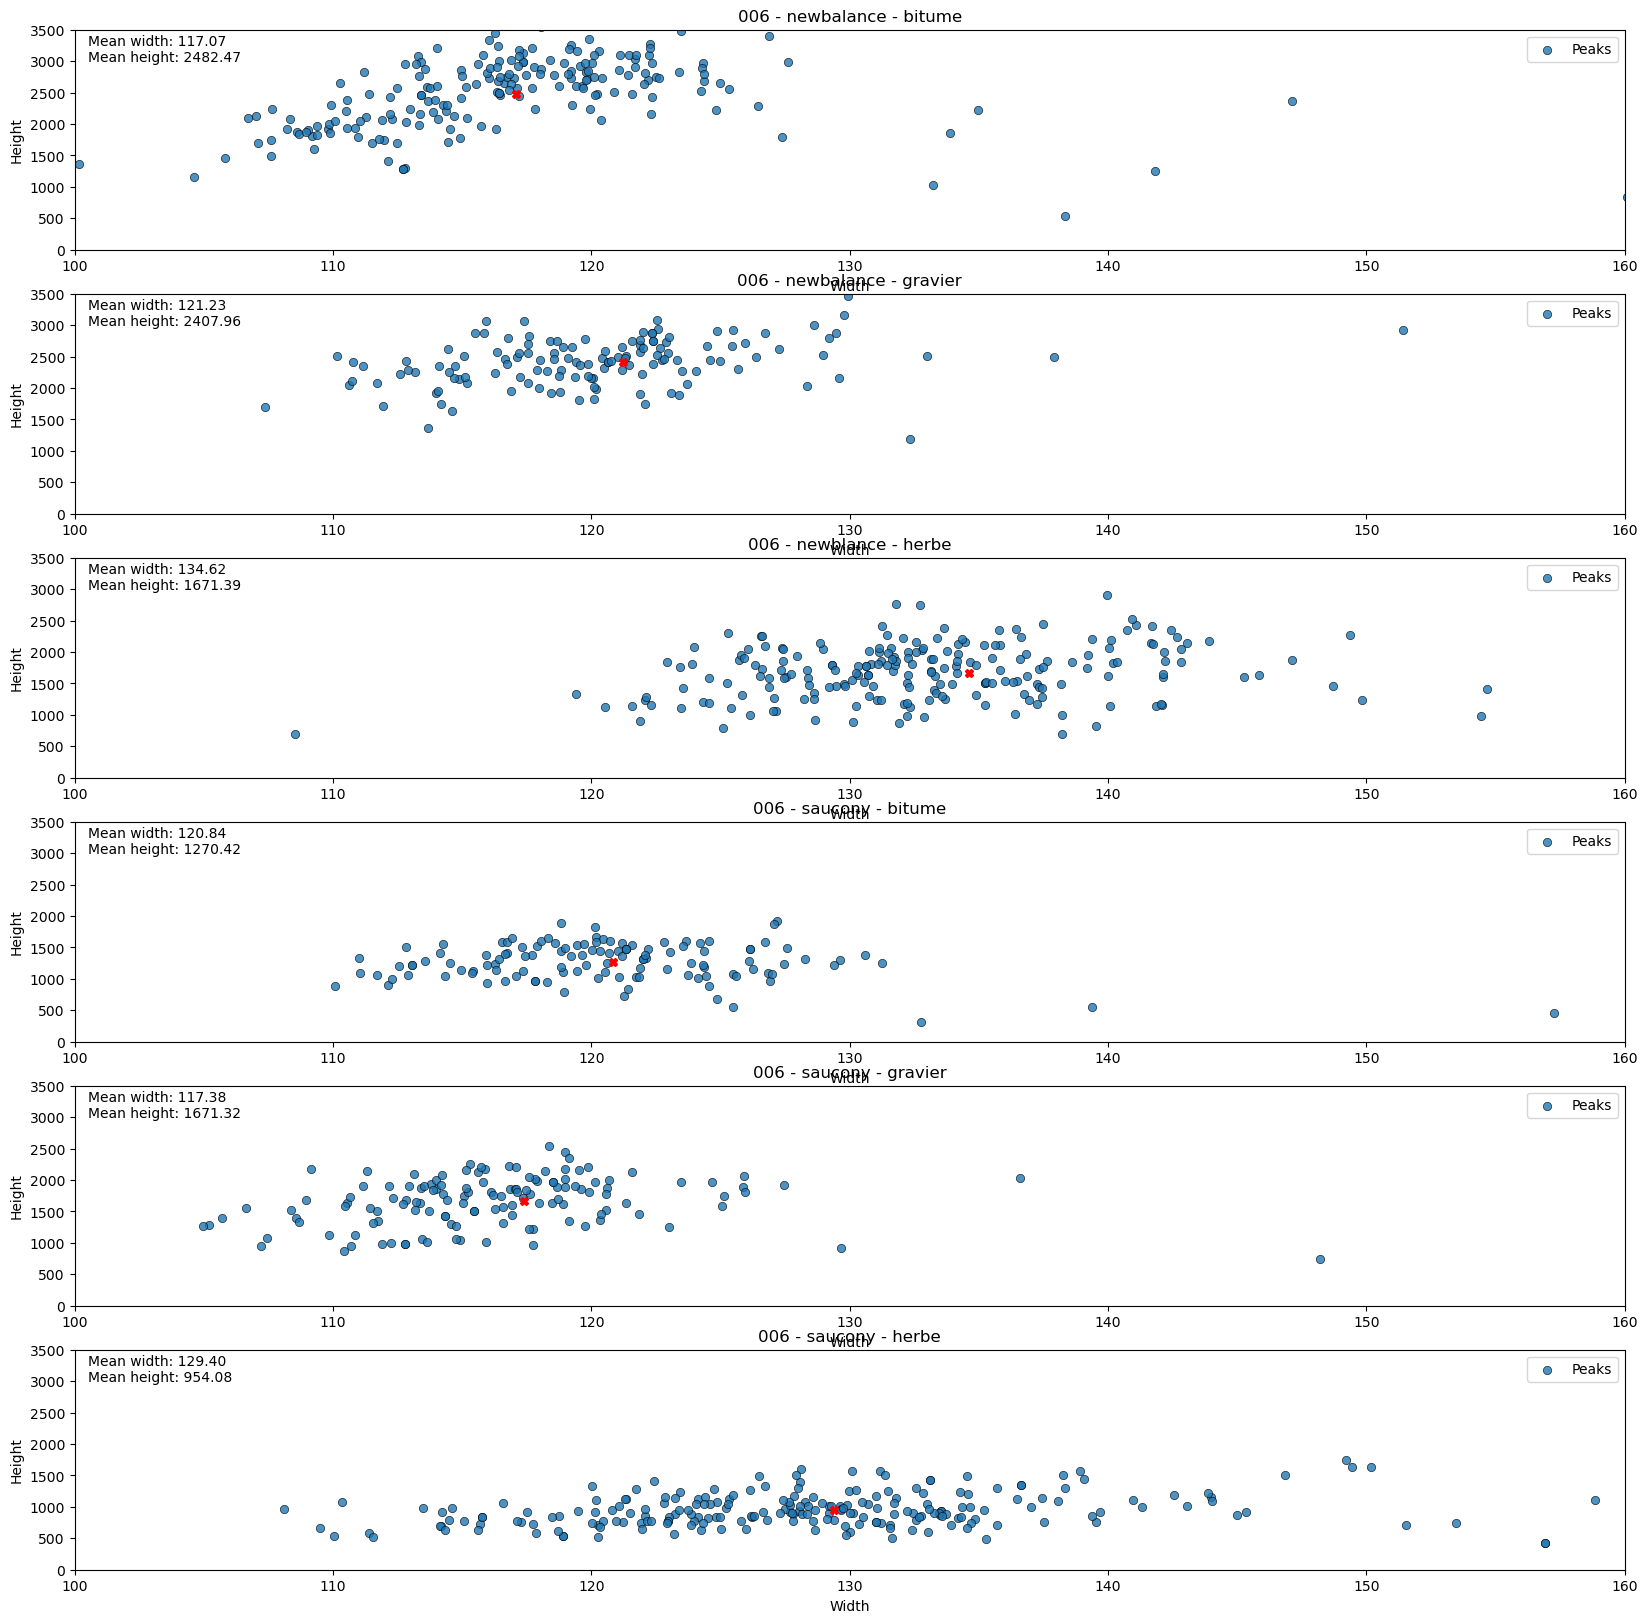

In [6]:
# Dow the same for other samples
def plot_data(data, channel):
    channel = 'Channel ' + str(channel);
    # Plot in subplots for each entry
    fig, axs = plt.subplots(len(data), 1 , figsize=(20, 20))
    for i, (session, shoes, coating, df) in enumerate(data):
        df_trim = df[0:-1000]
        peaks, _ = signal.find_peaks(df_trim[channel], height=300, prominence=150, width=50)

        widths = signal.peak_widths(df_trim[channel], peaks, rel_height=0.97)
        mean_width = np.mean(widths[0])
        mean_height = np.mean(df_trim[channel][peaks])

        axs[i].scatter(widths[0],df_trim[channel][peaks], label='Peaks', alpha=0.8, linewidths=0.5, edgecolors='black')
        axs[i].plot(mean_width ,mean_height, 'Xr')
        axs[i].set_title(f'{session} - {shoes} - {coating}')
        axs[i].set_xlabel('Width')
        axs[i].set_ylabel('Height')
        axs[i].set_xlim([100, 160])
        axs[i].set_ylim([0, 3500])
        # Display the mean width and height
        axs[i].text(100.5, 3000, f'Mean width: {mean_width:.2f} \nMean height: {mean_height:.2f}')

        axs[i].legend()
    plt.show()

plot_data(datas,2)

In [7]:
def get_peaks(data, channel, window=300):
    channel = 'Channel ' + str(channel);

    peaks_res = []

    for i, (session, shoes, coating, df) in enumerate(data):
        peaks_session = []
        df_trim = df[1000:-1000]
        peaks, _ = signal.find_peaks(df_trim[channel], height=300, prominence=150, width=50)
        for j in range(len(peaks)):
            peak = peaks[j]
            sig_peak = np.array(df_trim[channel][peak-window:peak+window])
            if len(sig_peak) == window*2:
                peaks_session.append(sig_peak)
        peaks_res.append(peaks_session)
    return peaks_res

window = 100
peaks_extracted = [get_peaks(datas, channel, window) for channel in range(1,5)]



In [8]:
def mean_peak_signal(data, channel):
    peaks = peaks_extracted[channel-1]
    mean_sigs = []
    for i, (session, shoes, coating, df) in enumerate(data):
        mean_sig = np.mean(peaks[i], axis=0)
        mean_sigs.append(mean_sig)
    return mean_sigs

mean_peaks = [mean_peak_signal(datas, channel) for channel in range(1,5)]


/home/malaury/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/malaury/.local/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


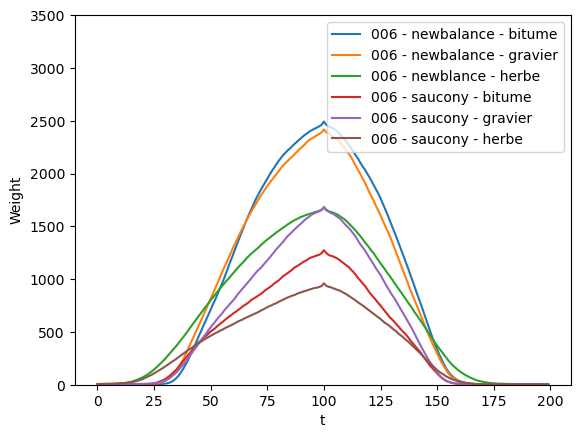

In [9]:
def plot_mean_peak(data, channel):
    mean_peak = mean_peaks[channel-1]
    channel = 'Channel ' + str(channel);
    # Plot in subplots for each entry
    for i, (session, shoes, coating, df) in enumerate(data):
        df_trim = df[0:-1000]
        peaks, _ = signal.find_peaks(df_trim[channel], height=300, prominence=150, width=50)

        widths = signal.peak_widths(df_trim[channel], peaks, rel_height=0.97)
        mean_width = np.mean(widths[0])
        mean_height = np.mean(df_trim[channel][peaks])

        plt.plot(mean_peak[i], label=f'{session} - {shoes} - {coating}')
    plt.xlabel('t')
    plt.ylabel('Weight')
    plt.ylim([0, 3500])
    plt.legend()

plot_mean_peak(datas, 2)

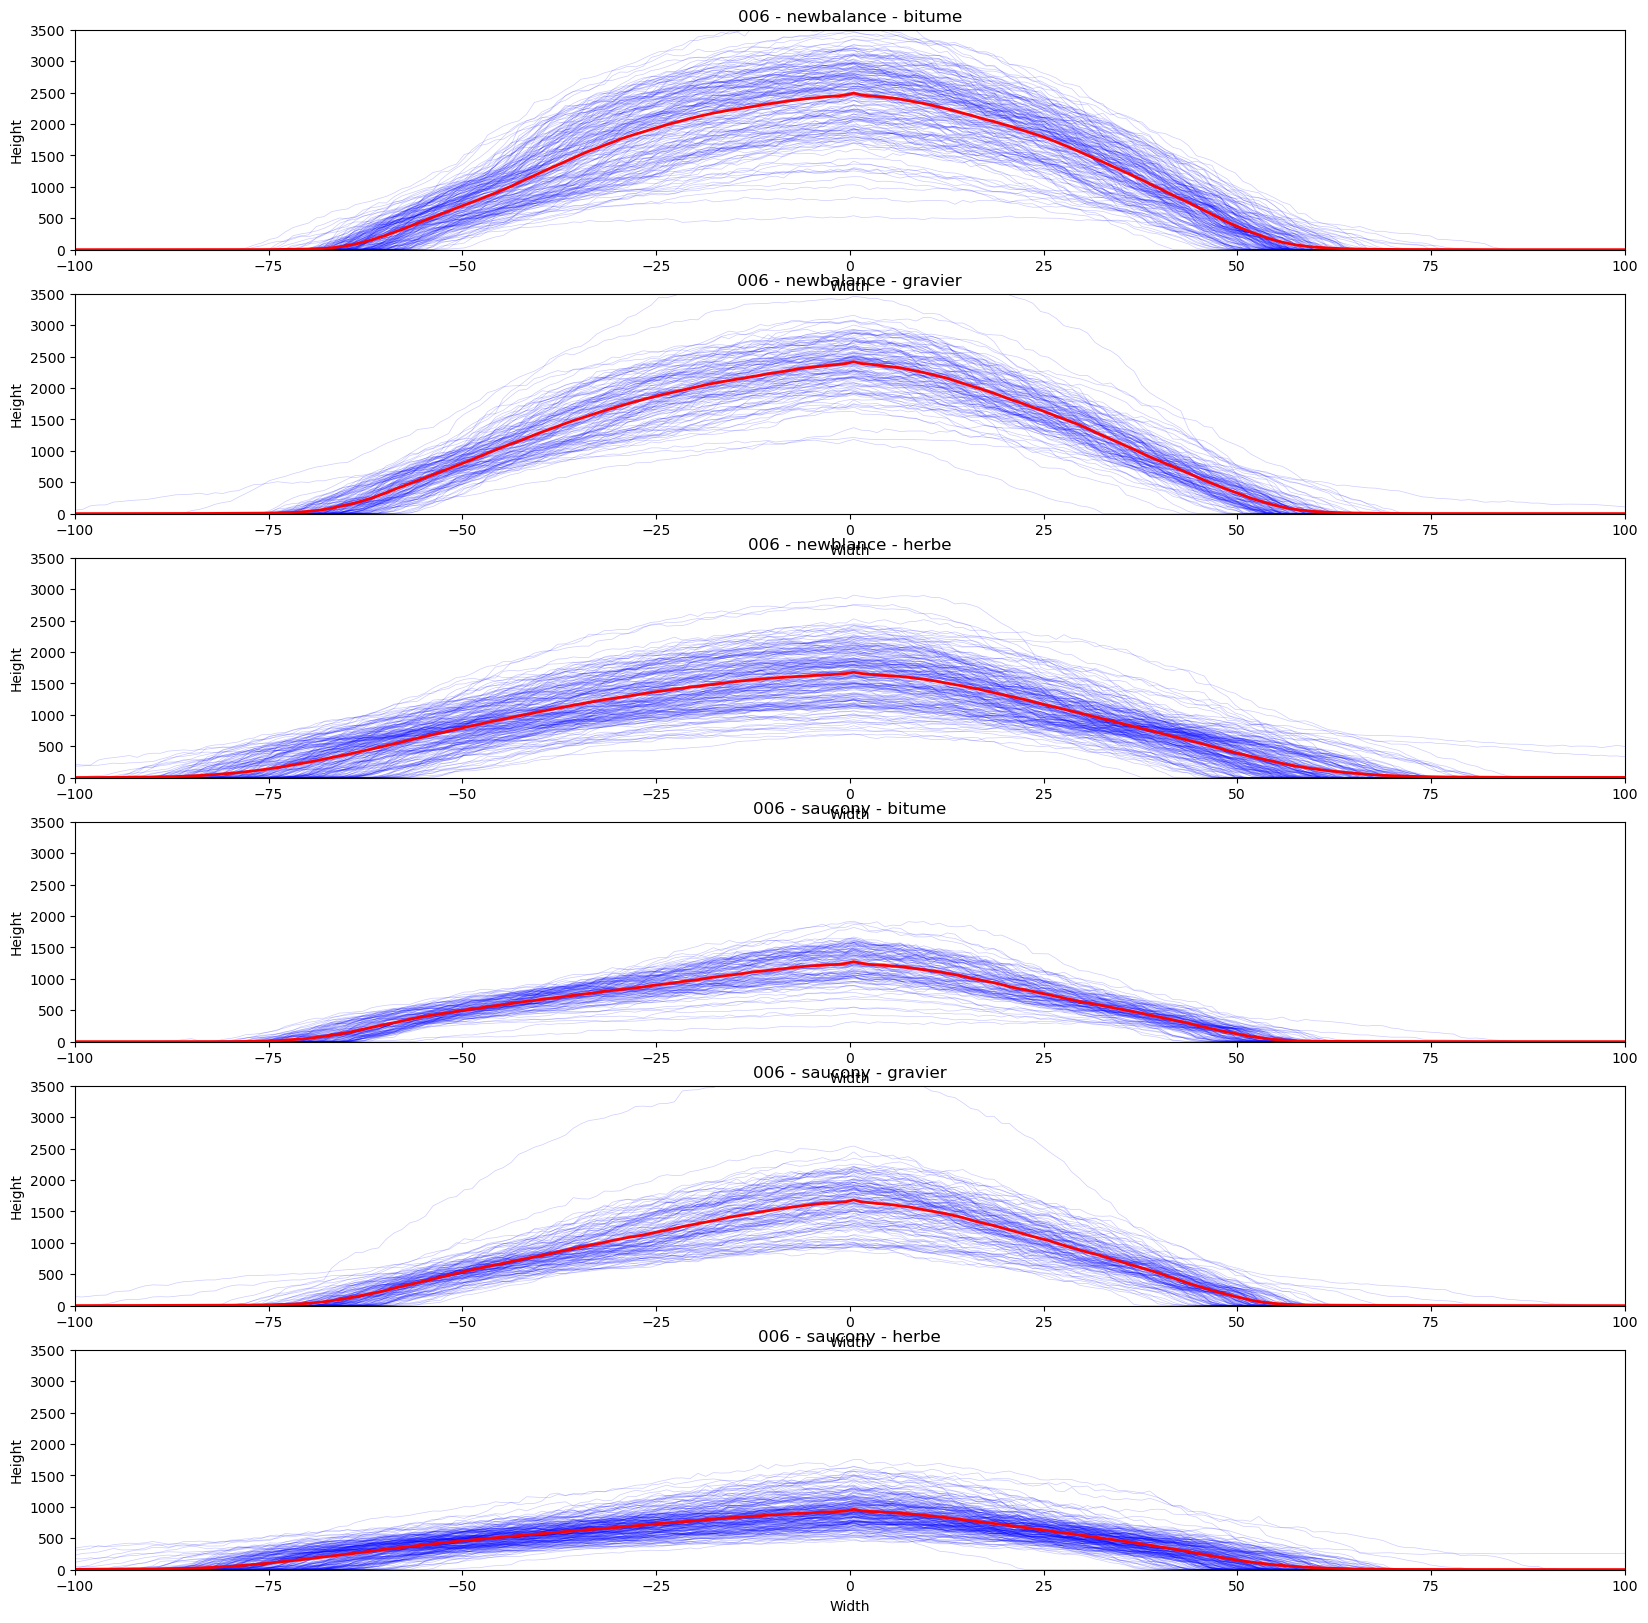

In [10]:
# Plot average peak
def plot_peaks(data, channel):
    peaks = peaks_extracted[channel-1]
    mean_peaks_ch = mean_peaks[channel-1]
    channel = 'Channel ' + str(channel);
    # Plot in subplots for each entry
    fig, axs = plt.subplots(len(data), 1 , figsize=(20, 20))
    for i, (session, shoes, coating, df) in enumerate(data):
        for j in range(len(peaks[i])):
            axs[i].plot(np.linspace(-window, window, 2*window),peaks[i][j], label='Peaks', alpha=0.2, color='blue', linewidth=0.5)

        axs[i].plot(np.linspace(-window, window, 2*window),mean_peaks_ch[i], label='Mean peak', color='red', linewidth=2)
        axs[i].set_title(f'{session} - {shoes} - {coating}')
        axs[i].set_xlabel('Width')
        axs[i].set_ylabel('Height')
        axs[i].set_xlim([-window, window])
        axs[i].set_ylim([0, 3500])


        
    plt.show()
            

plot_peaks(datas,2)

In [11]:
def save_peak(peak):
    dict = {}
    for i in range(len(peak)):
        session, shoes, coating, df = datas[i]
        dict[f'{session} - {shoes} - {coating}'] = peak[i]

    pd.DataFrame(data=dict).to_csv('motif.csv', index=False)

save_peak(mean_peaks[1])